## Entailment Classification with Graph Matching

In [1]:
from utils_model import EntailmentDataset, Vocabulary, word_tokenizer
from display_results import predict, draw_alignment, display_attention
from model import Seq2Seq
from graph_matching import *
import pandas as pd
import torch
import spacy
from spacy.tokens import Token
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline

config = {"BATCH_SIZE" : 32,
          "HID_DIM" : 512,
          "N_LAYERS" : 2,
          "DROPOUT" : 0.3}

##### Build the vocabulary from the dataset used to train Entailment Generation model.
\* (specify the folder where the training partition of SNLI dataset is saved)

In [3]:
train_data = EntailmentDataset.load_dataset(r"\folder", split="train")
voc = Vocabulary.build_vocabulary(train_data)

##### Load the pretrained GTE model
\* (specify the path to the .tar file with checkpoint)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load model checkpoint
checkpoint = torch.load(r"\Attention_additive_layer.tar")

# instantiate the model
model = Seq2Seq(pretrained_w2v = torch.zeros(checkpoint["model"]["embedding.weight"].shape, device=device),
                hidden_size = config["HID_DIM"],
                n_layers = config["N_LAYERS"],
                dropout = config["DROPOUT"],
                device = device,
                additive_attention = True)

# load the weights from checkpoint
model.load_state_dict(checkpoint['model'])
model = model.to(device)

#####  Load source sentences 
\* (use .xlsx file in \data)

In [8]:
sentences = pd.read_excel("\entailment_data.xlsx")
nlp = spacy.load("en_core_web_sm") 

#####  Graph matching and entailment categorization

PREMISE:  A surfer is performing a jumping stunt in the ocean .
ENTAILED SENTENCE:  A surfer is doing a trick .

Attention matching:
 ['do -> perform', 'surfer -> surfer', 'trick -> stunt']
Attention Scores: [0.277 0.438 0.308]

Graph matching:
 ['do -> perform', 'surfer -> surfer', 'trick -> stunt']
Similarity Scores: [0.643 1.    0.5  ]

Semantically related terms: {('trick', 'stunt'), ('do', 'perform')}
Possible Inference: set()
Estimate for syntactic subsumption: 0.25
Estimate for lexical semantics: 0.667
Estimate for high order inference 0.0


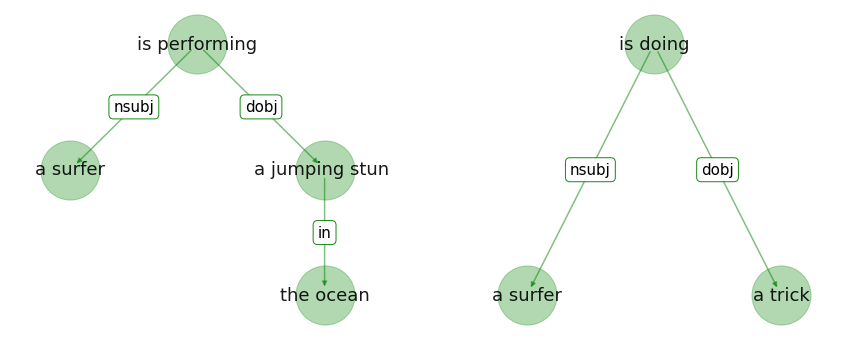

In [15]:
sample = 36
premise = sentences.iloc[sample][1]

# generate entailed sentence using the pretrained GTE model
hypo, attention_weights = predict(premise, model, voc, device)
prem = " ".join(word_tokenizer(premise))
print("PREMISE: ", prem.capitalize())
print("ENTAILED SENTENCE: ", hypo.capitalize())
print()

# generate graphical representation of premise and hypothesis
nlp_hypo = nlp(hypo)
nlp_prem = nlp(prem)
H_graph = generate_graph(nlp_hypo)
T_graph = generate_graph(nlp_prem )
attention = retrieve_attention(nlp_prem , nlp_hypo, attention_weights)

# draw syntactic trees of premise(left) and hypothesis(right)
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
draw_graph(T_graph, axs[0]), draw_graph(H_graph, axs[1])

# perform graph matching
m = GraphMatch(T_graph, H_graph)
m.graph_match() # graph_match
m.attention_match(attention) # attention_match

print("Attention matching:\n", list(f"{node} -> {image}" for (node, image) in m.attention_mapping))
print("Attention Scores:", np.around(np.max(m.attention_scores_array, axis=1), decimals = 3))
print()

print("Graph matching:\n", list(f"{node} -> {image}" for (node, image) in m.mapping))
print("Similarity Scores:", np.around(np.max(m.scores_array, axis=1), decimals = 3))
print()

# classify entailment relation
classify_entailment(m.attention_mapping, m.mapping, T_graph, H_graph)